In [1]:
!git clone -b atm-10 http://github.com/Zapy67/ATML-PA-4 

Cloning into 'ATML-PA-4'...


remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 173 (delta 114), reused 108 (delta 54), pack-reused 0 (from 0)
Receiving objects: 100% (173/173), 351.25 KiB | 7.17 MiB/s, done.
Resolving deltas: 100% (114/114), done.


In [364]:
!git pull  http://github.com/Zapy67/ATML-PA-4 atm-10

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 1.81 KiB | 617.00 KiB/s, done.
From http://github.com/Zapy67/ATML-PA-4
 * branch            atm-10     -> FETCH_HEAD
Updating 8a75371..7cf720b
Fast-forward
 fed_lib/fed_methods.py |   9 ++-
 fedsam.ipynb           | 189 +++++++++++++++++++++++++------------------------
 2 files changed, 101 insertions(+), 97 deletions(-)


In [365]:
%cd ATML-PA-4

[Errno 2] No such file or directory: 'ATML-PA-4'
/kaggle/working/ATML-PA-4


In [366]:
!ls

'ATML - PA 4.pdf'   fed_lib	   LICENSE     task1.ipynb   task3.ipynb
 data		    fedsam.ipynb   README.md   task2.ipynb   task4.ipynb


#  FedSAM on heterogeneous domains

In [367]:
import torch
import torch.nn as nn

In [368]:
import fed_lib
import importlib
importlib.reload(fed_lib)


<module 'fed_lib' from '/kaggle/working/ATML-PA-4/fed_lib/__init__.py'>

In [345]:
!pip install fedlab

In [369]:
from fed_lib import fed_methods, fed_model, utils
importlib.reload(utils)
importlib.reload(fed_methods)
importlib.reload(fed_model)

<module 'fed_lib.fed_model' from '/kaggle/working/ATML-PA-4/fed_lib/fed_model.py'>

In [370]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [371]:
trainset, testset = utils.get_cifar10()

In [220]:
client_loaders = utils.get_heterogenous_domains(trainset, clients=5, balance=False, min_require_size=20, alpha=2, verbose=True)

In [221]:
for idx, loader in enumerate(client_loaders):
    utils.calculate_label_skew(loader.dataset)

Label Distribution (P(Y)): [0.135 0.081 0.05  0.02  0.115 0.225 0.106 0.07  0.057 0.141]
Entropy of Label Distribution H(P(Y)): 2.0564825184573094
Normalized Entropy of Label Distribution: 0.8931190098965116

Label Distribution (P(Y)): [0.027 0.112 0.003 0.073 0.148 0.044 0.074 0.163 0.138 0.218]
Entropy of Label Distribution H(P(Y)): 1.9754108527507208
Normalized Entropy of Label Distribution: 0.8579100328414351

Label Distribution (P(Y)): [0.096 0.186 0.215 0.221 0.015 0.032 0.163 0.073]
Entropy of Label Distribution H(P(Y)): 1.7868040713990159
Normalized Entropy of Label Distribution: 0.8592711242825233

Label Distribution (P(Y)): [0.23  0.123 0.058 0.059 0.077 0.084 0.077 0.087 0.021 0.185]
Entropy of Label Distribution H(P(Y)): 2.04168839858929
Normalized Entropy of Label Distribution: 0.8866940052732156

Label Distribution (P(Y)): [0.061 0.015 0.151 0.109 0.135 0.113 0.075 0.101 0.24 ]
Entropy of Label Distribution H(P(Y)): 1.9621266396109156
Normalized Entropy of Label Distribut

In [222]:
client_weights = [len(client.dataset.indices)/len(trainset.dataset) for client in client_loaders]
domains = None

In [223]:
client_weights

[0.20124, 0.20774, 0.21058, 0.14286, 0.23758]

In [372]:
partition = "dirichlet"
alpha = 1
num_clients = 1
domains=None
fed = fed_model.Federation(num_clients, None, partition, domains, alpha, device, batch_size=64, pin_memory=True, num_workers=2)

In [373]:
client_loaders = fed.client_dataloaders
client_weights = [len(client.dataset.indices)/len(trainset.dataset) for client in client_loaders]

In [374]:
fed_method = fed_methods.FedSAM(sam_rho=0, 
             num_local_steps=1563, 
             client_aggregation_weights= client_weights)
fed.set_method(fed_method)

In [375]:
fed_method.client_weights

[1.0]

In [376]:
fed.train(5, lr=1e-3, verbose=False, momentum = 0, weight_decay=0)


--- Round 1/5 ---
Training Clients
Training Client 1/1
Training Server
1.0
SmallCNN(
  (backbone): Sequential(
    (0): SmallConvBlock(in_channels=3, out_channels=32)
    (1): SmallConvBlock(in_channels=32, out_channels=64)
    (2): SmallConvBlock(in_channels=64, out_channels=128)
  )
  (task_head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


ModuleNotFoundError: No module named 'utils'

In [360]:
utils.evaluate_model_on_test(fed.clients[0], testset, criterion= nn.CrossEntropyLoss(reduction="sum"), device=device)

(28.528918557739257, 0.688)

In [361]:
utils.compare_model_parameters(fed.server, fed.clients[0])

Comparing Model 1 vs Model 2

Top 5 layers with largest L2 differences:
Layer                                         L2 Diff     Rel Diff
task_head.1.weight                       1.239598e+00 1.669677e-01
backbone.2.block.3.weight                1.228977e+00 1.597127e-01
backbone.2.block.0.weight                1.049747e+00 1.424053e-01
backbone.1.block.3.weight                8.744065e-01 1.561376e-01
backbone.1.block.0.weight                7.768739e-01 1.402595e-01
Overall Statistics:
Total L2 difference:        2.490630e+00
Total parameters:           551,466


{'total_l2': 2.4906301003480755,
 'total_linf': 0.053399957716464996,
 'avg_relative_diff': 0.11714144235104751,
 'num_parameters': 551466}

truck
07:46:35 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


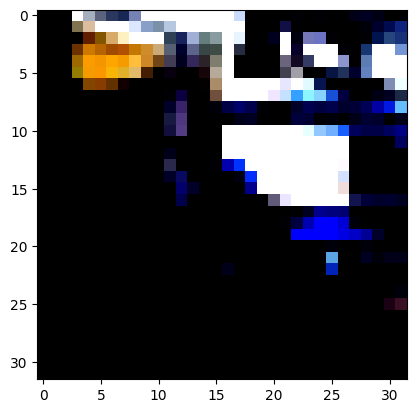

In [247]:
X, Y = next(iter(trainset))
import matplotlib.pyplot as plt

print(trainset.dataset.classes[Y[0].item()])
plt.imshow(X[0].permute(1,2,0))
